# Sequential Low Rank Regression

## Key Contributions:

1. **[Sub-routine agnostic]** We characterize how the errors from approximately solving the sub-routine (`PCA`) propagate into the overall error of the deflation procedure. Informally, the error between the approximately principal component and the actual one needs to be exponentially small to control the accuracy for the top-*K* eigenvectors for an increasing *K*, where the base of the exponential growth depends on the eigengap of the target matrix.
2. **[Sub-routing specific]** We consider the case where `PCA` is set to `Power Iteration` method. By leveraging the directional information of the numerical error vector produced by each power iteration, we improve the error bound in the previous step to exponential growth with constant base

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds, eigs

## Step 0: Initialization

In [12]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds, eigs

# STEP 0: Initialization

# Dimension of the matrix W (W = AB^T)
d = 100
m = 100
n = 400  # Number of samples
r = 10  # Rank of the matrix W

# Generating n input data points with d features with a normal distribution
X = np.random.randn(n, d)

# Normalizing the rows of X
X = X / la.norm(X, axis=1, keepdims=True)

# Generating Sigma, the diagonal matrix
# S = np.linspace(1, 10, r)
S = np.geomspace(100, 1, num=r)
S = np.diag(np.sqrt(S))

# Generating M
M = np.random.randn(d, m)
[U, temp, V] = la.svd(M)  # Performing SVD on M

# Generating A^* and B^*
A_star_hat = U[:, :r]  # Top-r left singular vectors
B_star_hat = V[:r, :].T  # Top-r right singular vectors

# Generating A* and B*
A_star = A_star_hat @ S
B_star = B_star_hat @ S
W_star = A_star @ B_star.T
# W_star = W_star / la.norm(W_star, 'fro')

# Noise
std = 5e-1
Z = np.random.randn(n, m)
Z = std * (1 / la.norm(Z, 'fro')) * Z

# Generating Y
Y = X @ W_star + Z

#Calculating the Lipschitz constant of H (Spectral Norm)
H = X.T @ X
[u, s, v] = svds(H, k=1)
L = s

# Setting learning rate eta
eta = 1/L[0]
print(f"Learning rate `eta` = {eta}")

Learning rate `eta` = 0.12099343641559762


## Step 1

### Step 1.1: Implementing Simple Gradient Descent

In [13]:
def GD(X, Y, W_star, n, d, m, r, eta, iters, epsilon):
    W_old = np.random.randn(d, m)
    i = 1
    while i <= iters:
        grad = X.T @ (X @ W_old - Y)

        # print(la.matrix_rank(grad))

        W_new = W_old - eta * grad

        # check if the relative change in W is smaller than the convergence
        # threshold (for stopping the algorithm)
        if la.norm(W_new - W_old, ord='fro') / la.norm(W_new, ord='fro') < epsilon:
            break

        W_old = W_new
        i += 1
    return W_new
# W_star and r are not used in the function yet

In [15]:
# Sanity check for the GD function

iters = 250  # Number of iterations
epsilon = 1e-8  # Convergence threshold

W = GD(X, Y, W_star, n, d, m, r, eta, iters, epsilon)
print(f"Rank of W: {la.matrix_rank(W)}")

Rank of W: 100


### Step 1.2: Implementing Iterative Hard-Thresholding [Projected Gradient Descent]

In [44]:
def IHT(X, Y, W_star, n, d, m, r, eta, iters, epsilon):
    
    W_old = np.random.randn(d, m)
    errors = []
    i = 1
    while i <= iters:
        grad = X.T @ (X @ W_old - Y)
        
        # print(la.matrix_rank(grad))

        W_mid = W_old - eta * grad

        # Projecting W_new to become r-rank
        U, S, V = la.svd(W_mid)
        W_new = U[:, :r] @  np.diag(S[:r]) @ V[:r,:]

        # Compute the error
        error = la.norm(W_new - W_star, ord = 'fro')/la.norm(W_star, ord = 'fro')
        errors.append(error)

        if error < epsilon:
            break
        W_old = W_new

        i += 1
    return W_new, errors
# W_star is not used in the function yet


In [16]:
# Sanity check for the IHT function

W_IHT, errors = IHT(X, Y, W_star, n, d, m, r, eta, iters, epsilon)

print(f"Rank of W_IHT: {la.matrix_rank(W_IHT)}")

Rank of W_proj: 10


In [18]:
print(f"Distance between W and W_star: {la.norm(W - W_star, ord='fro')}")
print(f"Distance between W_IHT and W_star: {la.norm(W_IHT - W_star, ord='fro')}\n")

print(f"Relative Error of W: {la.norm(W - W_star, ord='fro') / la.norm(W_star, ord='fro')}")
print(f"Relative Error of W_IHT: {la.norm(W_IHT - W_star, ord='fro') / la.norm(W_star, ord='fro')}\n")

Distance between W and W_star: 0.14262081632752646
Distance between W_proj and W_star: 0.059124663972385166

Relative Error of W: 0.0011415383476913535
Relative Error of W_proj: 0.00047323436337544356



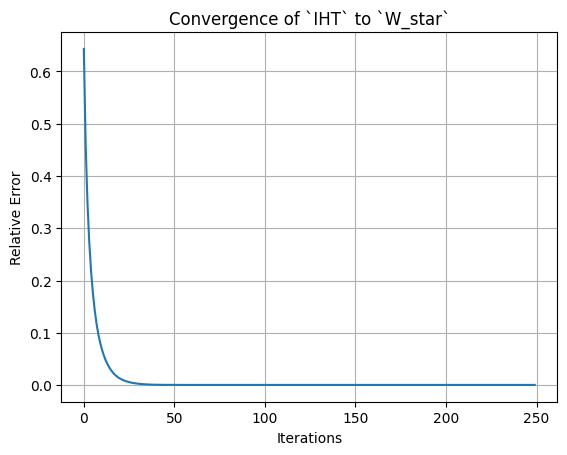

In [27]:
# Plotting the error
plt.plot(errors)
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("Relative Error")
plt.title("Convergence of `IHT` to `W_star`")
plt.show()

## Comparing rank-1 IHT approximations of `W*` with that of the actual `W*`  

In [96]:
# Initializing iters and epsilon
iters = 1000
epsilon = 1e-16

W_r1_components = np.zeros((r, d, m))

Y_res = Y.copy()

# Computing the SVD of W_star
U, S, V = la.svd(W_star, full_matrices=False)
print(f"Left Singular Matrix `U`: {U.shape}")
print(f"Singular Values `S`: {S.shape}")
print(f"Right Singular Matrix `V`: {V.shape}\n")

# Initializing the sum of the r-rank components
W_IHT_sum = np.zeros_like(W_star)
W_SVD_sum = np.zeros_like(W_star)

# Relative error between the IHT and SVD components
rel_error_IHT_SVD = np.zeros(r)

for i in range(r):
    ## IHT + Deflation
    # IHT
    W_IHT, errors = IHT(
        X, Y_res, W_star, n, d, m, r=1, eta=eta, iters=iters, epsilon=epsilon
    )
    # Storing the r-rank components
    W_r1_components[i] = W_IHT
    
    # Adding the r-rank component to the sum
    W_IHT_sum += W_IHT
    
    # Deflation
    Y_res = Y_res - X @ W_IHT
    
    ## SVD
    W_SVD = S[i] * np.outer(U[:, i], V[i, :])
    
    # Adding the r-rank component to the sum
    W_SVD_sum += W_SVD
    
    # Computing the relative error between the IHT and SVD components
    rel_error_IHT_SVD[i] = la.norm(W_IHT - W_SVD, ord='fro') / la.norm(W_SVD, ord='fro')
    print(f"Rank {i+1:02d} - Sigma_{i+1:02d}: {S[i]:.05f} | Relative Error (IHT, SVD): {rel_error_IHT_SVD[i]}")
    
# Rank-r reconstruction error
print("Relative error (W_IHT_sum, W_SVD_sum): ", la.norm(W_IHT_sum - W_SVD_sum, ord='fro') / la.norm(W_SVD_sum, ord='fro'))

Left Singular Matrix `U`: (100, 100)
Singular Values `S`: (100,)
Right Singular Matrix `V`: (100, 100)

Rank 01 - Sigma_01: 100.00000 | Relative Error (IHT, SVD): 0.030859280839197315
Rank 02 - Sigma_02: 59.94843 | Relative Error (IHT, SVD): 0.0835595979480465
Rank 03 - Sigma_03: 35.93814 | Relative Error (IHT, SVD): 0.12939883442249348
Rank 04 - Sigma_04: 21.54435 | Relative Error (IHT, SVD): 0.0756698566652007
Rank 05 - Sigma_05: 12.91550 | Relative Error (IHT, SVD): 0.14545471092229617
Rank 06 - Sigma_06: 7.74264 | Relative Error (IHT, SVD): 0.16916988888192816
Rank 07 - Sigma_07: 4.64159 | Relative Error (IHT, SVD): 0.11634470819288527
Rank 08 - Sigma_08: 2.78256 | Relative Error (IHT, SVD): 0.08346444922927747
Rank 09 - Sigma_09: 1.66810 | Relative Error (IHT, SVD): 0.12571703534535877
Rank 10 - Sigma_10: 1.00000 | Relative Error (IHT, SVD): 0.17444222612268442
Relative error (W_IHT_sum, W_SVD_sum):  0.0004732343633754213


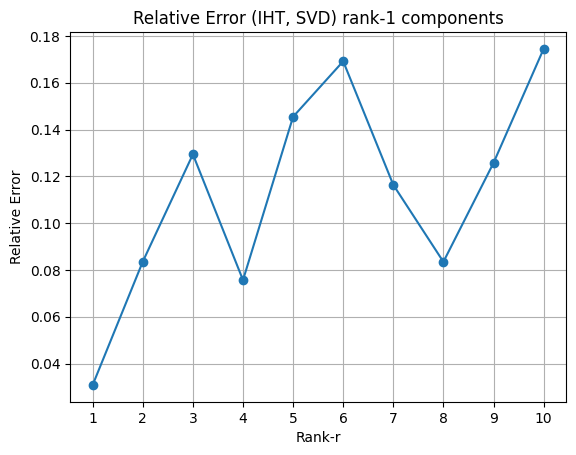

In [106]:
# Plotting the relative error between the IHT and SVD components
plt.plot(range(1, r+1), rel_error_IHT_SVD, marker='o')
plt.xticks(range(1, r+1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Relative Error (IHT, SVD) rank-1 components")
plt.grid()
plt.show()


Rank 01 - Relative Error: 0.5997564122774224
Rank 02 - Relative Error: 0.3604431130099096
Rank 03 - Relative Error: 0.21564977092236254
Rank 04 - Relative Error: 0.12950704212358402
Rank 05 - Relative Error: 0.07774010868623345
Rank 06 - Relative Error: 0.046244613435266875
Rank 07 - Relative Error: 0.027295443458253608
Rank 08 - Relative Error: 0.015714277217496034
Rank 09 - Relative Error: 0.008132319249184798
Rank 10 - Relative Error: 0.00047323436337543174


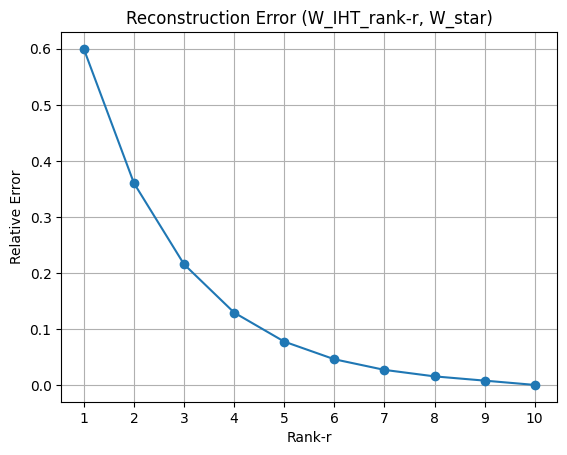

In [109]:
# Cumulative error of rank-r approximation using IHT+Deflation method
W_r_errors = np.zeros(r)

for i in range(r):
    W_r = np.sum(W_r1_components[:i+1], axis=0)
    W_r_errors[i] = la.norm(W_r - W_star, ord='fro') / la.norm(W_star, ord='fro')
    print(f"Rank {i+1:02d} - Relative Error: {W_r_errors[i]}")
    
# Plotting the Cumulative error of rank-r approximation
plt.plot(range(1, r+1), W_r_errors, marker='o')
plt.xticks(range(1, r+1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Cumulative Error (W_IHT_rank-r, W*)")
plt.grid()

plt.show()

Rank 01 - Relative Error: 0.030859280839197315
Rank 02 - Relative Error: 0.04079185257856391
Rank 03 - Relative Error: 0.012888082135749697
Rank 04 - Relative Error: 0.013496997740903186
Rank 05 - Relative Error: 0.011475129779068763
Rank 06 - Relative Error: 0.004726908754204146
Rank 07 - Relative Error: 0.0028020500857376066
Rank 08 - Relative Error: 0.002203953092645867
Rank 09 - Relative Error: 0.0014483636090838715
Rank 10 - Relative Error: 0.0004732343633754213


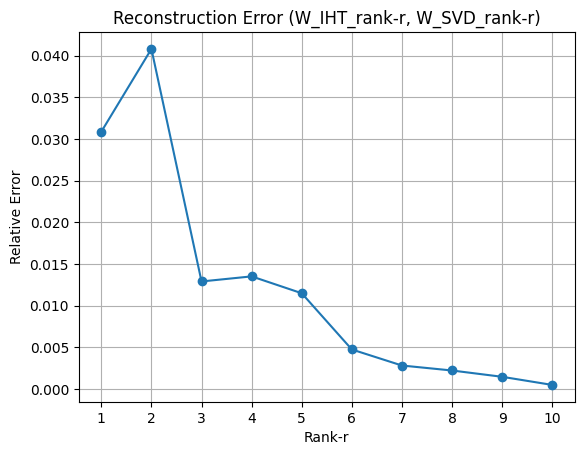

In [108]:
# Reconstruction error of rank-r approximation using IHT+Deflation method
W_r_errors = np.zeros(r)

for i in range(r):
    W_r = np.sum(W_r1_components[:i+1], axis=0)
    W_star_i = np.sum([S[j] * np.outer(U[:, j], V[j, :]) for j in range(i+1)], axis=0)
    W_r_errors[i] = la.norm(W_r - W_star_i, ord='fro') / la.norm(W_star_i, ord='fro')
    print(f"Rank {i+1:02d} - Relative Error: {W_r_errors[i]}")
    
# Plotting the reconstruction error of rank-r approximation
plt.plot(range(1, r+1), W_r_errors, marker='o')
plt.xticks(range(1, r+1))
plt.xlabel("Rank-r")
plt.ylabel("Relative Error")
plt.title("Reconstruction Error (W_IHT_rank-r, W_SVD_rank-r)")
plt.grid()

plt.show()